In [ ]:
# ! pip install git+https://github.com/catalyst-team/catalyst@kittylyst scikit-learn>=0.20 optuna --upgrade

In [ ]:
# ! pip install catalyst==21.01rc0 scikit-learn>=0.20 optuna --upgrade

###  Catalyst 21.xx demo

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_blobs
%matplotlib inline

In [2]:
from typing import *

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset

from catalyst import dl, metrics, utils

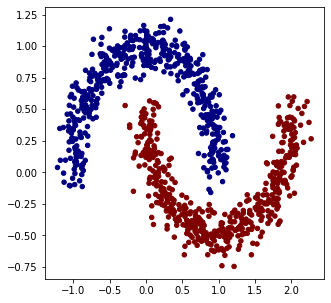

In [3]:
# make up a dataset
def make_dataset(seed=42, n_samples=int(1e3)):
    np.random.seed(seed)
    random.seed(seed)
    X, y = make_moons(n_samples=n_samples, noise=0.1)

    y = y*2 - 1 # make y be -1 or 1
    return X, y

def visualize_dataset(X, y):
    plt.figure(figsize=(5,5))
    plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

# let's create train data
X_train, y_train = make_dataset()
visualize_dataset(X_train, y_train)

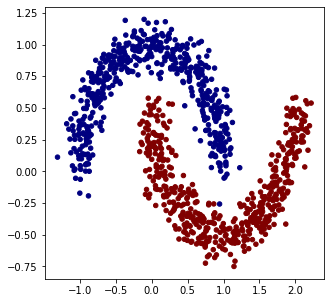

In [4]:
# valid data
X_valid, y_valid = make_dataset(seed=137)
visualize_dataset(X_valid, y_valid)

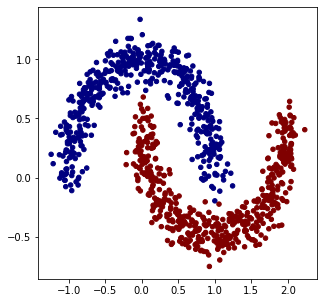

In [5]:
# and another train one (why not?)
X_train2, y_train2 = make_dataset(seed=1337)
visualize_dataset(X_train2, y_train2)

In [6]:
# initialize a model 
# 2-layer neural network
model = nn.Sequential(
    nn.Linear(2, 16), nn.ReLU(), 
    nn.Linear(16, 16), nn.ReLU(), 
    nn.Linear(16, 1)
)
print(model)
# print("number of parameters", len(model.parameters()))

Sequential(
  (0): Linear(in_features=2, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=1, bias=True)
)


In [7]:
def visualize_decision_boundary(X, y, model):
    h = 0.25
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Xmesh = np.c_[xx.ravel(), yy.ravel()]
    
    inputs = torch.tensor([list(xrow) for xrow in Xmesh]).float()
    scores = model(inputs)
    
    Z = np.array([s.data > 0 for s in scores])
    Z = Z.reshape(xx.shape)

    fig = plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()
    return fig

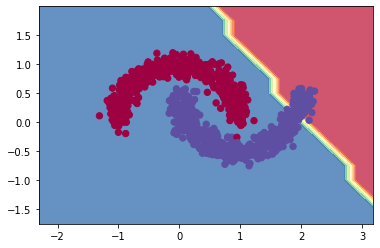

In [8]:
_ = visualize_decision_boundary(X_valid, y_valid, model)

In [9]:
t1 = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train > 0).float())
t2 = TensorDataset(torch.tensor(X_train2).float(), torch.tensor(y_train2 > 0).float())
v1 = TensorDataset(torch.tensor(X_valid).float(), torch.tensor(y_valid > 0).float())

loaders = {
    "train_1": DataLoader(t1, batch_size=32, num_workers=1), 
    "train_2": DataLoader(t2, batch_size=32, num_workers=1), 
    "valid": DataLoader(v1, batch_size=32, num_workers=1), 
}

---

### Act 1 - ``CustomRunner – batch handling by you own``

In [ ]:
# # 2-layer neural network
# model = nn.Sequential(
#     nn.Linear(2, 16), nn.ReLU(), 
#     nn.Linear(16, 16), nn.ReLU(), 
#     nn.Linear(16, 1)
# )
# optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
# experiment = dl.SingleStageExperiment(
#     model=model, 
#     optimizer=optimizer, 
#     loaders=loaders, 
#     num_epochs=5
# )

# class CustomRunner(dl.IStageBasedRunner):
#     def handle_batch(self, batch):
#         x, y = batch
#         y_hat = self.model(x)

#         loss = F.binary_cross_entropy_with_logits(y_hat.view(-1), y)
#         self.batch_metrics = {"loss": loss}
#         if self.loader_batch_step % 50 == 0:
#             print(
#                 f"{self.loader_key} ({self.loader_batch_step}/{self.loader_batch_len}:" 
#                 f"loss {loss.item()}"
#             )

#         if self.is_train_loader:
#             loss.backward()
#             self.optimizer.step()
#             self.optimizer.zero_grad()

# CustomRunner().run(experiment)

In [ ]:
# _ = visualize_decision_boundary(X_valid, y_valid, model)

---

### Act 2 - ``SupervisedRunner – Runner with Callbacks``

In [10]:
num_epochs=5
model = nn.Sequential(
    nn.Linear(2, 16), nn.ReLU(), 
    nn.Linear(16, 16), nn.ReLU(), 
    nn.Linear(16, 1)
)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [2, 4])

experiment = dl.SingleStageExperiment(
    model=model, 
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    loaders=loaders, 
    num_epochs=num_epochs,
    callbacks={
# Let's use AUC metric as an example – it's loader-based, so we shouldn't compute it on each batch
        "auc": dl.MetricCallback(
            metric=metrics.AUCMetric(), compute_on_batch=False,
            input_key="scores", target_key="targets", 
        ), 
# To wrap the criterion step logic, you could use CriterionCallback:
        "criterion": dl.CriterionCallback(
            metric_key="loss", 
            input_key="logits", 
            target_key="targets"
        ), 
# To wrap the optimizer step logic, you could use OptimizerCallback:
        "optimizer": dl.OptimizerCallback(metric_key="loss"), 
# The same case with the scheduler:
        "scheduler": dl.SchedulerCallback(
            loader_key="valid", metric_key="loss"
        ),
# We could also use lrfinder for lr scheduling:
#         "lr-finder": dl.LRFinder(
#             final_lr=1.0,
#             scale="log",
#             num_steps=None,
#             optimizer_key=None,
#         ),
# You can select any number of metrics to checkpoint on:
        "checkpoint1": dl.CheckpointCallback(
            logdir="./logdir2/auc",
            loader_key="valid", metric_key="auc", 
            minimize=False, save_n_best=3
        ),
        "checkpoint2": dl.CheckpointCallback(
            logdir="./logdir2/loss",
            loader_key="valid", metric_key="loss", 
            minimize=True, save_n_best=1
        ),
# Or turn on/off tqdm verbose during loader run:
        "verbose": dl.VerboseCallback(),
    },
    loggers={
        "console": dl.ConsoleLogger(),
#         "csv": dl.LogdirLogger(logdir="./logdir2"),
        "tensorboard": dl.TensorboardLogger(logdir="./logdir2/tb"),
    }
)

class CustomSupervisedRunner(dl.IStageBasedRunner):
    def handle_batch(self, batch):
        x, y = batch
        y_hat = self.model(x)
        
        self.batch = {
            "features": x,
            "targets": y,
            "logits": y_hat.view(-1),
            "scores": torch.sigmoid(y_hat.view(-1)),
        }

CustomSupervisedRunner().run(experiment)

Hparams (experiment): {}



train_1 (1/5) auc: 0.8857880234718323 | auc/class_01: 0.8857880234718323 | loss: 0.43154561924934387 | loss/std: 0.18190671809524567



train_2 (1/5) auc: 0.9644119739532471 | auc/class_01: 0.9644119739532471 | loss: 0.2472540961503982 | loss/std: 0.08407046908312064



valid (1/5) auc: 0.9702200293540955 | auc/class_01: 0.9702200293540955 | loss: 0.234219463288784 | loss/std: 0.09544606312109175
* Epoch (1/5) lr: 0.02 | momentum: 0.9



train_1 (2/5) auc: 0.9712039828300476 | auc/class_01: 0.9712039828300476 | loss: 0.21572261953353883 | loss/std: 0.09676932872631994



train_2 (2/5) auc: 0.9759399890899658 | auc/class_01: 0.9759399890899658 | loss: 0.20005200362205508 | loss/std: 0.0692437969033986



valid (2/5) auc: 0.9843159914016724 | auc/class_01: 0.9843159914016724 | loss: 0.17627789959311485 | loss/std: 0.07777968664485643
* Epoch (2/5) lr: 0.002 | momentum: 0.9



train_1 (3/5) auc: 0.9843239784240723 | auc/class_01: 0.9843239784240723 | loss: 0.16445403456687926 | loss/std: 0.0672861972555817



train_2 (3/5) auc: 0.985427975654602 | auc/class_01: 0.985427975654602 | loss: 0.15997130051255223 | loss/std: 0.05083957292074935



valid (3/5) auc: 0.9876599907875061 | auc/class_01: 0.9876599907875061 | loss: 0.15146324917674067 | loss/std: 0.06650151497485715
* Epoch (3/5) lr: 0.002 | momentum: 0.9



train_1 (4/5) auc: 0.9874719977378845 | auc/class_01: 0.9874719977378845 | loss: 0.14798793804645538 | loss/std: 0.060587624961374056



train_2 (4/5) auc: 0.9882680177688599 | auc/class_01: 0.9882680177688599 | loss: 0.14587891349196433 | loss/std: 0.04733151261546089



valid (4/5) auc: 0.9905679821968079 | auc/class_01: 0.9905679821968079 | loss: 0.1367575930058956 | loss/std: 0.06200554468050372
* Epoch (4/5) lr: 0.0002 | momentum: 0.9



train_1 (5/5) auc: 0.990227997303009 | auc/class_01: 0.990227997303009 | loss: 0.13620436000823977 | loss/std: 0.05749203115641195



train_2 (5/5) auc: 0.9888399839401245 | auc/class_01: 0.9888399839401245 | loss: 0.14061330968141555 | loss/std: 0.048250319489712964



valid (5/5) auc: 0.9912880063056946 | auc/class_01: 0.9912880063056946 | loss: 0.13344491904973985 | loss/std: 0.058529590312604615
* Epoch (5/5) lr: 0.0002 | momentum: 0.9
Top best models:
logdir2/auc/train.5.pth	0.9913
logdir2/auc/train.4.pth	0.9906
logdir2/auc/train.3.pth	0.9877
Top best models:
logdir2/loss/train.5.pth	0.1334


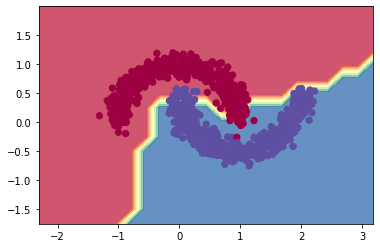

In [11]:
_ = visualize_decision_boundary(X_valid, y_valid, model)

---

### Act 3 - ``CustomMetric``

In [ ]:
num_epochs=5
model = nn.Sequential(
    nn.Linear(2, 16), nn.ReLU(), 
    nn.Linear(16, 16), nn.ReLU(), 
    nn.Linear(16, 1)
)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [2, 4])


class CustomAccuracyMetric(metrics.AverageMetric):
    def update(self, scores: torch.Tensor, targets: torch.Tensor) -> None:
        value = ((scores > 0.5) == targets).float().mean()
        super().update(value, len(targets))

    def compute_key_value(self) -> Dict[str, float]:
        mean, std = super().compute()
        return {"accuracy": mean, "accuracy/std": std}

    
experiment = dl.SingleStageExperiment(
    model=model, 
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    loaders=loaders, 
    num_epochs=num_epochs,
    callbacks={
        "accuracy": dl.MetricCallback(
            metric=CustomAccuracyMetric(), compute_on_batch=True,
            input_key="scores", target_key="targets", 
        ),
        "auc": dl.MetricCallback(
            metric=metrics.AUCMetric(), compute_on_batch=False,
            input_key="scores", target_key="targets", 
        ), 
        "criterion": dl.CriterionCallback(
            metric_key="loss", 
            input_key="logits", 
            target_key="targets"
        ), 
        "optimizer": dl.OptimizerCallback(metric_key="loss"), 
        "scheduler": dl.SchedulerCallback(
            loader_key="valid", metric_key="loss"
        ),
        "checkpoint1": dl.CheckpointCallback(
            loader_key="valid", metric_key="accuracy", 
            minimize=False, save_n_best=3
        ),
        "checkpoint2": dl.CheckpointCallback(
            loader_key="valid", metric_key="loss", 
            minimize=True, save_n_best=1
        ),
#         "verbose": dl.VerboseCallback(),
    },
    loggers={
        "console": dl.ConsoleLogger(),
        "tensorboard": dl.TensorboardLogger(logdir="./logdir3"),
    }
)

class CustomSupervisedRunner(dl.IStageBasedRunner):
    def handle_batch(self, batch):
        x, y = batch
        y_hat = self.model(x)
        
        self.batch = {
            "features": x,
            "targets": y,
            "logits": y_hat.view(-1),
            "scores": torch.sigmoid(y_hat.view(-1)),
        }

CustomSupervisedRunner().run(experiment)

In [ ]:
_ = visualize_decision_boundary(X_valid, y_valid, model)

---

### Act 4 - ``CustomCallback``

In [ ]:
num_epochs=5
model = nn.Sequential(
    nn.Linear(2, 16), nn.ReLU(), 
    nn.Linear(16, 16), nn.ReLU(), 
    nn.Linear(16, 1)
)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [2, 4])


# Let's plot the decision doundary after each epoch:
class VisualizationCallback(dl.Callback):
    def __init__(self):
        super().__init__(order=dl.CallbackOrder.External)

    def on_epoch_end(self, runner):
        img = visualize_decision_boundary(X_valid, y_valid, runner.model)


experiment = dl.SingleStageExperiment(
    model=model, 
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    loaders=loaders, 
    num_epochs=num_epochs,
    callbacks={
        "criterion": dl.CriterionCallback(
            metric_key="loss", 
            input_key="logits", 
            target_key="targets"
        ), 
        "optimizer": dl.OptimizerCallback(metric_key="loss"), 
        "scheduler": dl.SchedulerCallback(
            loader_key="valid", metric_key="loss"
        ),
        "checkpoint": dl.CheckpointCallback(
            loader_key="valid", metric_key="loss", 
            minimize=True, save_n_best=1
        ),
# And include it into callbacks:        
        "visualization": VisualizationCallback()
    },
    loggers={
        "console": dl.ConsoleLogger(),
        "tensorboard": dl.TensorboardLogger(logdir="./logdir4"),
    }
)

class CustomSupervisedRunner(dl.IStageBasedRunner):
    def handle_batch(self, batch):
        x, y = batch
        y_hat = self.model(x)
        
        self.batch = {
            "features": x,
            "targets": y,
            "logits": y_hat.view(-1),
            "scores": torch.sigmoid(y_hat.view(-1)),
        }

CustomSupervisedRunner().run(experiment)

---

### Act 5 - ``CustomLogger``

In [ ]:
import io
import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_img_from_fig(fig, dpi=180):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=dpi)
    buf.seek(0)
    
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    img = cv2.imdecode(img_arr, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [ ]:
num_epochs=5
model = nn.Sequential(
    nn.Linear(2, 16), nn.ReLU(), 
    nn.Linear(16, 16), nn.ReLU(), 
    nn.Linear(16, 1)
)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [2, 4])


# We need to add only a few lines to log the image to all runner's loggers
class VisualizationCallback(dl.Callback):
    def __init__(self):
        super().__init__(order=dl.CallbackOrder.External)

    def on_epoch_end(self, runner):
        img = visualize_decision_boundary(X_valid, y_valid, runner.model)
        img = get_img_from_fig(img)
        # runner will propagate it to all loggers
        runner.log_image(img, scope="epoch")


# Let's also add our own Logger to store image on the disk
class VisualizationLogger(dl.ILogger):
    def __init__(self, logdir: str):
        self.logdir = logdir
        os.makedirs(self.logdir, exist_ok=True)
        
    def log_image(
        self,
        image: np.ndarray,
        scope: str = None,
        # experiment info
        experiment_key: str = None,
        global_epoch_step: int = 0,
        global_batch_step: int = 0,
        global_sample_step: int = 0,
        # stage info
        stage_key: str = None,
        stage_epoch_len: int = 0,
        stage_epoch_step: int = 0,
        stage_batch_step: int = 0,
        stage_sample_step: int = 0,
        # loader info
        loader_key: str = None,
        loader_batch_len: int = 0,
        loader_sample_len: int = 0,
        loader_batch_step: int = 0,
        loader_sample_step: int = 0,
    ) -> None:
        if scope == "epoch":
            plt.imsave(
                os.path.join(self.logdir, f"img_{stage_key}_{stage_epoch_step}.png"),
                image,
            )


experiment = dl.SingleStageExperiment(
    model=model, 
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    loaders=loaders, 
    num_epochs=num_epochs,
    callbacks={
        "criterion": dl.CriterionCallback(
            metric_key="loss", 
            input_key="logits", 
            target_key="targets"
        ), 
        "optimizer": dl.OptimizerCallback(metric_key="loss"), 
        "scheduler": dl.SchedulerCallback(
            loader_key="valid", metric_key="loss"
        ),
        "checkpoint": dl.CheckpointCallback(
            loader_key="valid", metric_key="loss", 
            minimize=True, save_n_best=1
        ),
        "visualization": VisualizationCallback()
    },
    loggers={
        "console": dl.ConsoleLogger(),
        "visualization": VisualizationLogger(logdir="./logdir5"),
        "tensorboard": dl.TensorboardLogger(logdir="./logdir5"),
    }
)

class CustomSupervisedRunner(dl.IStageBasedRunner):
    def handle_batch(self, batch):
        x, y = batch
        y_hat = self.model(x)
        
        self.batch = {
            "features": x,
            "targets": y,
            "logits": y_hat.view(-1),
            "scores": torch.sigmoid(y_hat.view(-1)),
        }

CustomSupervisedRunner().run(experiment)

In [ ]:
! ls ./logdir5

### Act 6 - ``Multistage Experiment``

In [ ]:
import io
import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_img_from_fig(fig, dpi=180):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=dpi)
    buf.seek(0)
    
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    img = cv2.imdecode(img_arr, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [ ]:
loaders = {
    "stage_1": {
        "train_1": DataLoader(t1, batch_size=32, num_workers=1), 
        "valid": DataLoader(v1, batch_size=32, num_workers=1), 
    },
    "stage_2": {
        "train_2": DataLoader(t2, batch_size=32, num_workers=1), 
        "valid": DataLoader(v1, batch_size=32, num_workers=1), 
    },
}
stages = loaders.keys()
num_epochs=5

model = nn.Sequential(
    nn.Linear(2, 16), nn.ReLU(), 
    nn.Linear(16, 16), nn.ReLU(), 
    nn.Linear(16, 1)
)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [2, 4])


# let's define our own Experiment logic
# to unpack key-value loaders into a stages-based loaders:
class CustomExperiment(dl.SingleStageExperiment):
    @property
    def stages(self):
        return self._stage

    def get_loaders(self, stage: str):
        return self._loaders[stage]

    
class VisualizationCallback(dl.Callback):
    def __init__(self):
        super().__init__(order=dl.CallbackOrder.External)

    def on_epoch_end(self, runner):
        img = visualize_decision_boundary(X_valid, y_valid, runner.model)
        img = get_img_from_fig(img)
        runner.log_image(img, scope="epoch")


class VisualizationLogger(dl.ILogger):
    def __init__(self, logdir: str):
        self.logdir = logdir
        os.makedirs(self.logdir, exist_ok=True)
        
    def log_image(
        self,
        image: np.ndarray,
        scope: str = None,
        # experiment info
        experiment_key: str = None,
        global_epoch_step: int = 0,
        global_batch_step: int = 0,
        global_sample_step: int = 0,
        # stage info
        stage_key: str = None,
        stage_epoch_len: int = 0,
        stage_epoch_step: int = 0,
        stage_batch_step: int = 0,
        stage_sample_step: int = 0,
        # loader info
        loader_key: str = None,
        loader_batch_len: int = 0,
        loader_sample_len: int = 0,
        loader_batch_step: int = 0,
        loader_sample_step: int = 0,
    ) -> None:
        if scope == "epoch":
            plt.imsave(
                os.path.join(self.logdir, f"img_{stage_key}_{stage_epoch_step}.png"),
                image,
            )


experiment = CustomExperiment(
    model=model, 
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    loaders=loaders, 
    num_epochs=num_epochs,
    callbacks={
        "auc": dl.MetricCallback(
            metric=metrics.AUCMetric(), compute_on_batch=False,
            input_key="scores", target_key="targets", 
        ), 
        "criterion": dl.CriterionCallback(
            metric_key="loss", 
            input_key="logits", 
            target_key="targets"
        ), 
        "optimizer": dl.OptimizerCallback(metric_key="loss"), 
        "scheduler": dl.SchedulerCallback(
            loader_key="valid", metric_key="loss"
        ),
        "checkpoint1": dl.CheckpointCallback(
            loader_key="valid", metric_key="auc", 
            minimize=False, save_n_best=3
        ),
        "checkpoint2": dl.CheckpointCallback(
            loader_key="valid", metric_key="loss", 
            minimize=True, save_n_best=1
        ),
        "visualization": VisualizationCallback(),
#         "verbose": VerboseCallback(),
        
    },
    loggers={
        "console": dl.ConsoleLogger(),
        "visualization": VisualizationLogger(logdir="./logdir6"),
        "tensorboard": dl.TensorboardLogger(logdir="./logdir6"),
    },
# here is the trick for multi-stage support:
    stage=stages
)

class CustomRunner(dl.IStageBasedRunner):
    def handle_batch(self, batch):
        x, y = batch
        y_hat = self.model(x)
        
        self.batch = {
            "features": x,
            "targets": y,
            "logits": y_hat.view(-1),
            "scores": torch.sigmoid(y_hat.view(-1)),
        }

CustomRunner().run(experiment)

In [ ]:
! ls ./logdir6

In [ ]:
_ = visualize_decision_boundary(X_valid, y_valid, model)

---

### Act 8 - ``CustomExperiment``

In [ ]:
class CustomExperiment(dl.IExperiment):
    @property
    def seed(self) -> int:
        return 73

    @property
    def name(self) -> str:
        return "experiment73"

    @property
    def hparams(self) -> Dict:
        return {}

    @property
    def stages(self) -> List[str]:
        return ["stage_1", "stage_2"]

    def get_stage_params(self, stage: str) -> Dict[str, Any]:
        if stage == "stage_1":
            return {
                "num_epochs": 10,
                "migrate_model_from_previous_stage": False,
                "migrate_callbacks_from_previous_stage": False,
            }
        elif stage == "stage_2":
            return {
                "num_epochs": 6,
                "migrate_model_from_previous_stage": True,
                "migrate_callbacks_from_previous_stage": False,
            }
        else:
            raise NotImplemented()

    def get_loaders(self, stage: str) -> Dict[str, Any]:
        if stage == "stage_1":
            return {
                "train_1": DataLoader(t1, batch_size=32, num_workers=1), 
                "valid": DataLoader(v1, batch_size=32, num_workers=1), 
            }
        elif stage == "stage_2":
            return {
                "train_2": DataLoader(t2, batch_size=32, num_workers=1), 
                "valid": DataLoader(v1, batch_size=32, num_workers=1), 
            }
        else:
            raise NotImplemented()

    def get_model(self, stage: str):
        return nn.Sequential(
            nn.Linear(2, 16), nn.ReLU(), 
            nn.Linear(16, 16), nn.ReLU(), 
            nn.Linear(16, 1)
        )

    def get_criterion(self, stage: str):
        return nn.BCEWithLogitsLoss()

    def get_optimizer(self, stage: str, model):
        if stage == "stage_1":
            return torch.optim.Adam(model.parameters(), lr=0.02)
        elif stage == "stage_2":
            return torch.optim.SGD(model.parameters(), lr=0.01)
        else:
            raise NotImplemented()

    def get_scheduler(self, stage: str, optimizer):
        if stage == "stage_1":
            return torch.optim.lr_scheduler.MultiStepLR(optimizer, [3, 8])
        elif stage == "stage_2":
            return torch.optim.lr_scheduler.MultiStepLR(optimizer, [3, 6])
        else:
            raise NotImplemented()
        

    def get_callbacks(self, stage: str) -> Dict[str, dl.Callback]:
        if stage == "stage_1":
            
            return {
                "criterion": dl.CriterionCallback(
                    metric_key="loss", 
                    input_key="logits", 
                    target_key="targets"
                ), 
                "optimizer": dl.OptimizerCallback(metric_key="loss"), 
                "scheduler": dl.SchedulerCallback(
                    loader_key="valid", metric_key="loss"
                ),
                "checkpoint": dl.CheckpointCallback(
                    loader_key="valid", metric_key="loss", 
                    minimize=True, save_n_best=3
                ),
            }
        elif stage == "stage_2":
            return {
                "auc": dl.MetricCallback(
                    metric=metrics.AUCMetric(), compute_on_batch=False,
                    input_key="scores", target_key="targets", 
                ), 
                "criterion": dl.CriterionCallback(
                    metric_key="loss", 
                    input_key="logits", 
                    target_key="targets"
                ), 
                "optimizer": dl.OptimizerCallback(metric_key="loss"), 
                "scheduler": dl.SchedulerCallback(
                    loader_key="valid", metric_key="loss"
                ),
                "checkpoint_auc": dl.CheckpointCallback(
                    loader_key="valid", metric_key="auc", 
                    minimize=False, save_n_best=3
                ),
            }
        else:
            raise NotImplemented()
        

    def get_engine(self):
        if torch.cuda.is_available():
            return dl.DeviceEngine("cuda:0")
        else:
            return dl.DeviceEngine("cpu")

    def get_trial(self):
        return None

    def get_loggers(self):
        return {
            "console": dl.ConsoleLogger(),
            "tensorboard": dl.TensorboardLogger(logdir="./logdir7"),
        }

    
class CustomRunner(dl.IStageBasedRunner):
    def handle_batch(self, batch):
        x, y = batch
        y_hat = self.model(x)
        
        self.batch = {
            "features": x,
            "targets": y,
            "logits": y_hat.view(-1),
            "scores": torch.sigmoid(y_hat.view(-1)),
        }
    
experiment = CustomExperiment()
CustomRunner().run(experiment)

---

### Act 8 - integration with hyperparameter search

In [ ]:
from datetime import datetime
import optuna    

class CustomRunner(dl.IStageBasedRunner):
    def handle_batch(self, batch):
        x, y = batch
        y_hat = self.model(x)
        
        self.batch = {
            "features": x,
            "targets": y,
            "logits": y_hat.view(-1),
            "scores": torch.sigmoid(y_hat.view(-1)),
        }

def objective(trial):
    num_epochs = 6
    num_hidden1 = int(trial.suggest_loguniform("num_hidden1", 2, 16))
    num_hidden2 = int(trial.suggest_loguniform("num_hidden2", 2, 16))
    
    loaders = {
        "train_1": DataLoader(t1, batch_size=32, num_workers=1), 
        "train_2": DataLoader(t2, batch_size=32, num_workers=1), 
        "valid": DataLoader(v1, batch_size=32, num_workers=1), 
    }

    model = nn.Sequential(
        nn.Linear(2, num_hidden1), nn.ReLU(), 
        nn.Linear(num_hidden1, num_hidden2), nn.ReLU(), 
        nn.Linear(num_hidden2, 1)
    )
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [3, 6])

    experiment = dl.SingleStageExperiment(
        model=model, 
        criterion=criterion, 
        optimizer=optimizer, 
        scheduler=scheduler,
        loaders=loaders, 
        num_epochs=num_epochs,
        callbacks={
            "auc": dl.MetricCallback(
                metric=metrics.AUCMetric(), compute_on_batch=False,
                input_key="scores", target_key="targets", 
            ), 
            "criterion": dl.CriterionCallback(
                metric_key="loss", 
                input_key="logits", 
                target_key="targets"
            ), 
            "optimizer": dl.OptimizerCallback(metric_key="loss"), 
            "scheduler": dl.SchedulerCallback(
                loader_key="valid", metric_key="loss"
            ),
            "checkpoint": dl.CheckpointCallback(
                loader_key="valid", metric_key="auc", 
                minimize=False, save_n_best=3
            ),
            "optuna": dl.OptunaPruningCallback(loader_key="valid", metric_key="auc")
        },
        loggers={
            "console": dl.ConsoleLogger(),
            "tensorboard": dl.TensorboardLogger(logdir=f"./logdir8/{datetime.now().strftime('%Y%m%d-%H%M%S')}"),
        },
        trial=trial,
    )

    runner = CustomRunner()
    runner.run(experiment)
    score = runner.callbacks["checkpoint"].top_best_metrics[0][0]
    
    return score

study = optuna.create_study(
    direction="maximize",
#     direction="minimize",
    pruner=optuna.pruners.MedianPruner(
        n_startup_trials=0, n_warmup_steps=0, interval_steps=1
    ),
)
study.optimize(objective, n_trials=5, timeout=300)
print(study.best_value, study.best_params)

---

🎉 You have passed ``Kittylyst`` tutorial! This is just a minimal educational demo, but I hope you found it interesting for your deep learning research code organisation.

For more advanced and production-ready solution please follow our [Catalyst](https://github.com/catalyst-team/catalyst) repository.

PS. If you are interested in deep learning you could also try out our [dl-course](https://github.com/catalyst-team/dl-course).